## Notebook for tasmax's northern hemisphere summer 95th percentile maps in GDPCIR paper

* last updated : 2022/11/15, by Emile Tenezakis (e.tenezakis@gmail.com). 
* scaling : with a remote dask cluster as a backend to the xarray datasets. With the cluster scaling parameters as is, notebook should take around 10 minutes, including normal cluster spin up time. 
* output : notebook saves the figure to user specific `figure_3_output_file_path` defined below.
* library dependencies : This ran on rhodium's onyx environment, with the open source rhodium `rhg_compute_tools` and open source `dodola` packages pip-installed in editable mode (if using onyx, install both without their dependencies with the `--no-deps` flag).  
* data dependencies : publicly available GDPCIR datasets stored on google cloud, and a yaml file containing the URLs to these datasets. This yaml file is available in the GDPCIR github repository, specify your local path to it below with `fps_yaml_path`. 

In [1]:
import os

# put this wherever you want
FIGURE_OUTPUT_DIR = "."

REPO_ROOT = "../../"
assert "notebooks" in os.listdir(REPO_ROOT)

figure_3_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_3_tasmax_summer_q95_trend_with_biascorrected_clipped.png",
)


figure_a2_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_a2_tasmax_summer_q95_trend_diff_linear.png",
)

fps_yaml_path = os.path.join(
    REPO_ROOT,
    "notebooks/downscaling_pipeline/post_processing_and_delivery/data_paths.yaml",
)

model = "NorESM2-LM"
fut_scenario = "ssp370"
var = "tasmax"
months = [6, 7, 8]
quantile = 0.95
title = "95th Percentile JJA Maximum Temperature. SSP3-7.0. NorESM2-LM"

In [2]:
%%capture
try:
    import rhg_compute_tools
except ModuleNotFoundError:
    ! pip install rhg_compute_tools

try:
    import dodola.services
except ModuleNotFoundError:
    ! pip install --no-deps git+https://github.com/ClimateImpactLab/dodola

In [3]:
import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from cartopy.feature import NaturalEarthFeature
from dodola.services import xesmf_regrid
from rhg_compute_tools import kubernetes as rhgk

In [4]:
# each 50 workers get 1/2 a 48GiB Node.
# necessary to use half a node b/c of reanalysis.
client, cluster = rhgk.get_big_cluster()
cluster.scale(50);

In [5]:
def read_data(model, scenario, step_label, pix):
    with open(fps_yaml_path, "r") as f:
        fps = yaml.load(f, yaml.Loader)
    da_tasmax = xr.open_zarr(fps[f"{model}-tasmax"][scenario][step_label])["tasmax"]
    if pix is not None:
        da_tasmax = da_tasmax.isel(lat=pix["lat"], lon=pix["lon"], drop=True)
    if step_label == "biascorrected":
        # apply the swap to be consistent with downscaling
        da_tasmin = xr.open_zarr(fps[f"{model}-tasmin"][scenario][step_label])["tasmin"]
        if pix is not None:
            da_tasmin = da_tasmin.isel(lat=pix["lat"], lon=pix["lon"], drop=True)
        da_tasmax = xr.where(da_tasmin > da_tasmax, da_tasmin, da_tasmax)
    return da_tasmax

In [6]:
def gcm_q_trend(
    model,
    fut_scenario,
    var,
    step_label,
    fut_period=range(2080, 2100 + 1),
    hist_period=range(1995, 2014 + 1),
    months=months,
    quantile=quantile,
    pix=None,
) -> xr.DataArray:
    """
    calculate period difference in a seasonal quantile

    function that loads GCM data at the step `step_label` (raw, bias corrected,
    downscaled etc) from the URLs yaml file and computes the trend in a particular
    seasonal quantile of tasmax for `model`, scenario `fut_scenario`, variable `var.
    Trend is computed between `fut_period` and `hist_period`. Season is defined with
    `months`. Quantile is defined with `quantile`.

    You can locally, without the dask cluster, test the function with `pix`.
    """

    # read data, subset time series for fut
    fut = read_data(model=model, scenario=fut_scenario, step_label=step_label, pix=pix)
    fut = fut.where(fut.time.dt.year.isin(fut_period), drop=True)
    fut = fut.where(fut.time.dt.month.isin(months), drop=True)

    # same for hist
    hist = read_data(model=model, scenario="historical", step_label=step_label, pix=pix)
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    hist = hist.where(hist.time.dt.month.isin(months), drop=True)

    # if took only one pixel, load
    if pix is not None:
        fut = fut.load()
        hist = hist.load()
    else:
        # move chunks to space to take temporal quantile
        fut = fut.chunk({"time": -1, "lat": 360, "lon": 360})
        hist = hist.chunk({"time": -1, "lat": 360, "lon": 360})

    fut_q = fut.quantile(q=quantile, dim="time")
    hist_q = hist.quantile(q=quantile, dim="time")
    trend = fut_q - hist_q

    return trend

In [7]:
def regrid_to_coarse_resolution(da):
    domain_ds = xr.open_zarr("gs://support-c23ff1a3/domain.1x1.zarr", chunks=None)
    da = xesmf_regrid(
        x=xr.Dataset({"da": da}),
        domain=domain_ds,
        method="nearest_s2d",
        astype=np.float32,
        add_cyclic=None,
        keep_attrs=True,
    )["da"]
    return da


def regrid_to_downscaled_resolution(da):
    """
    regrid a lat/lon dataarray to the downscaling resolution using dodola's `xesmf_regrid`.
    """
    domain_ds = xr.open_zarr("gs://support-c23ff1a3/domain.0p25x0p25.zarr", chunks=None)
    da = xesmf_regrid(
        x=xr.Dataset({"da": da}),
        domain=domain_ds,
        method="nearest_s2d",
        astype=np.float32,
        add_cyclic=None,
        keep_attrs=True,
    )["da"]
    return da

In [8]:
def cyclic_lon(da):
    """
    [0, 360] - > [-180, 180]
    """
    return da.assign_coords(
        {"lon": xr.where(da.lon > 180, da.lon - 360, da.lon)}
    ).sortby("lon")

In [9]:
biascorrected_trend = gcm_q_trend(
    model=model, fut_scenario=fut_scenario, var=var, step_label="biascorrected"
)

In [10]:
biascorrected_trend = biascorrected_trend.compute()

In [11]:
biascorrected_trend = cyclic_lon(biascorrected_trend)
biascorrected_trend.values = np.ascontiguousarray(biascorrected_trend.values)
biascorrected_fine_trend = regrid_to_downscaled_resolution(biascorrected_trend)

In [12]:
with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    downscaled_trend = gcm_q_trend(
        model=model,
        fut_scenario=fut_scenario,
        var=var,
        step_label="downscaled_delivered",
    )

In [13]:
downscaled_trend = downscaled_trend.compute()

In [14]:
raw_cleaned_trend = gcm_q_trend(
    model=model,
    fut_scenario=fut_scenario,
    var=var,
    step_label="clean",
).compute()

raw_cleaned_trend = cyclic_lon(raw_cleaned_trend)
raw_cleaned_trend.values = np.ascontiguousarray(raw_cleaned_trend.values)

In [15]:
raw_cleaned_trend_regridded_coarse = regrid_to_coarse_resolution(raw_cleaned_trend)

In [16]:
raw_cleaned_trend_regridded_fine = regrid_to_downscaled_resolution(
    raw_cleaned_trend_regridded_coarse
)

In [17]:
raw_cleaned_trend_regridded_direct = regrid_to_downscaled_resolution(raw_cleaned_trend)

In [18]:
diff_downscaled_regriddedraw = downscaled_trend - raw_cleaned_trend_regridded_fine

In [19]:
diff_downscaled_biascorrected = downscaled_trend - biascorrected_fine_trend

In [20]:
diff_biascorrected_regriddedraw = (
    biascorrected_trend - raw_cleaned_trend_regridded_coarse
)

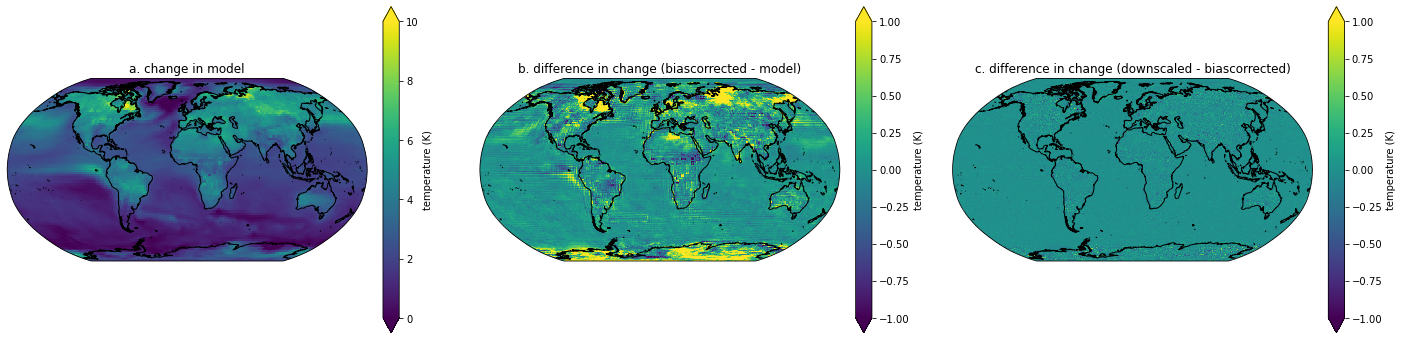

In [21]:
plot_kwargs = dict(vmin=0, vmax=10)
diff_plot_kwargs = dict(vmin=-1, vmax=1)
abs_plot_kwargs = dict(vmin=230, vmax=315)
all_pieces = [
    raw_cleaned_trend,
    diff_biascorrected_regriddedraw,
    diff_downscaled_biascorrected,
]
titles = [
    "a. change in model",
    "b. difference in change (biascorrected - model)",
    "c. difference in change (downscaled - biascorrected)",
]
kwargs_list = [plot_kwargs, diff_plot_kwargs, diff_plot_kwargs]
from copy import copy

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

all_pieces_copy = copy(all_pieces)
fig, axes = plt.subplots(
    ncols=len(all_pieces_copy),
    nrows=1,
    figsize=(24, 6),
    subplot_kw={"projection": ccrs.Robinson()},
)
coastline_feature = NaturalEarthFeature(
    "physical", "coastline", "50m", edgecolor="black", facecolor="none"
)
for i, _ in enumerate(all_pieces_copy):
    v, k, kw, ax = all_pieces_copy[i], titles[i], kwargs_list[i], axes[i]
    v["lat"].attrs = dict()
    v["lon"].attrs = dict()
    ax.add_feature(coastline_feature)
    im = all_pieces[i].plot(
        add_colorbar=True,
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs=dict(
            fraction=0.046,
            pad=0.04,
            orientation="vertical",
            extend="both",
            label="temperature (K)",
        ),
        **kwargs_list[i]
    )
    ax.set_title(titles[i])
    ax.set_xlabel("")
    ax.set_ylabel("")

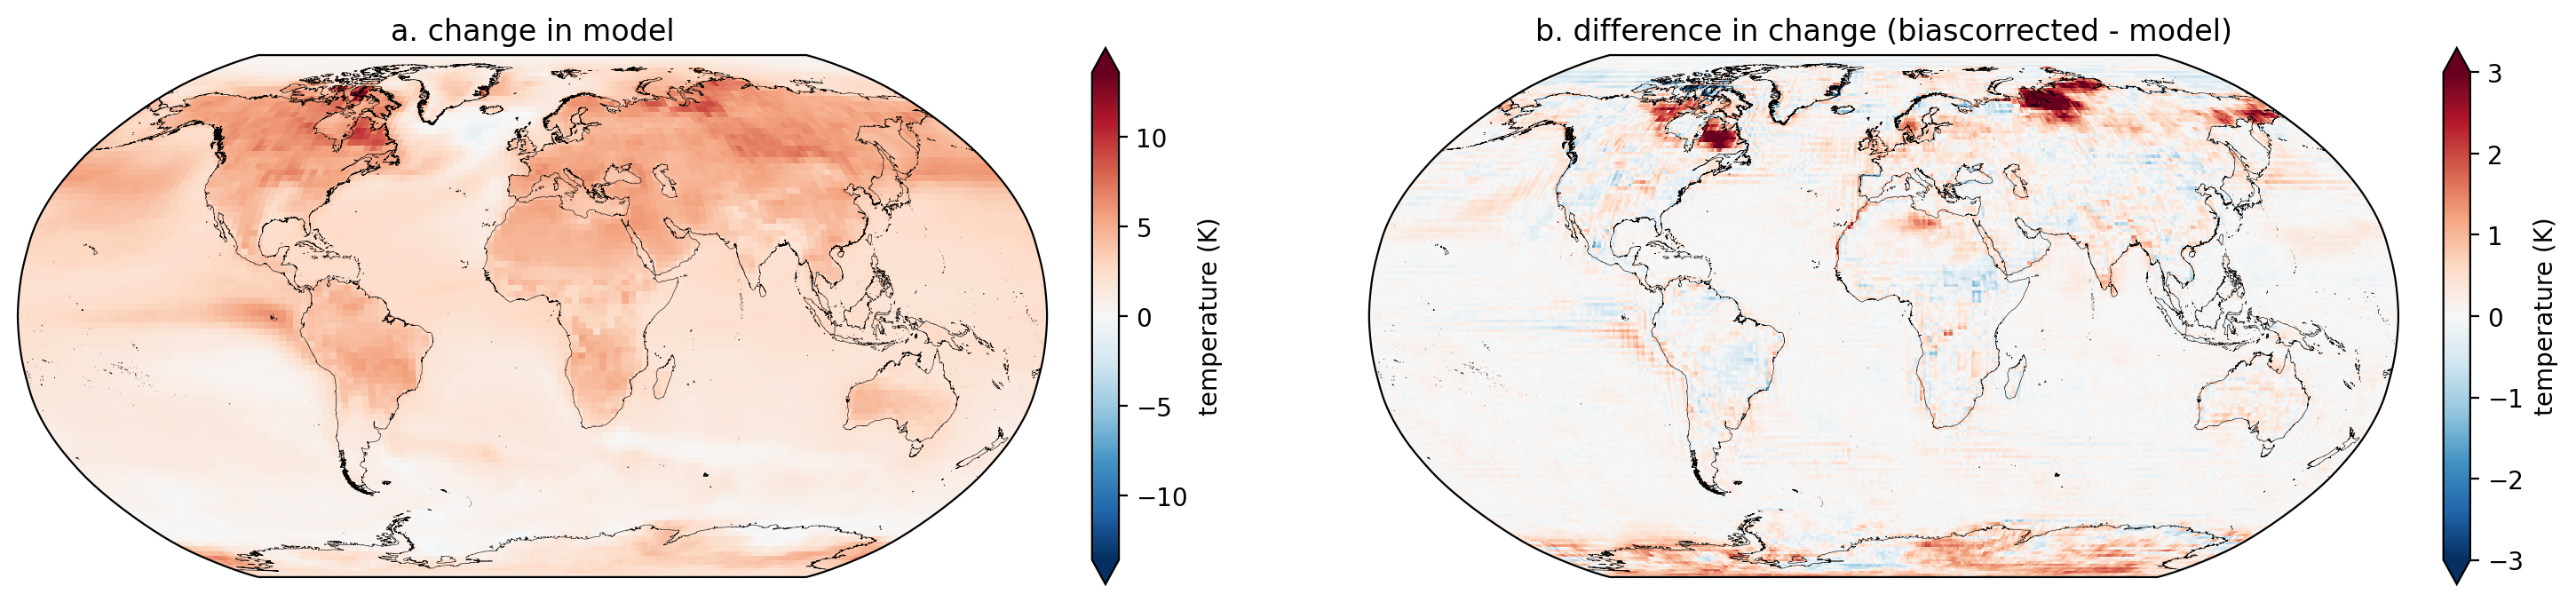

In [22]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(18, 4),
    subplot_kw={"projection": ccrs.Robinson()},
    dpi=200,
)
coastline_feature = NaturalEarthFeature(
    "physical", "coastline", "10m", edgecolor="black", facecolor="none"
)
titles = ["a. change in model", "b. difference in change (biascorrected - model)"]
for i, _ in enumerate(all_pieces_copy[:2]):
    v, k, kw, ax = all_pieces_copy[i], titles[i], kwargs_list[i], axes[i]
    v["lat"].attrs = dict()
    v["lon"].attrs = dict()
    ax.add_feature(coastline_feature, linewidth=0.2)
    da = all_pieces[i]
    vmax = da.max().item()
    vmin = da.min().item()

    if i == 1:
        vmin, vmax, amax = -3, 3, 3

    amax = max(abs(vmax), abs(vmin))
    norm = matplotlib.colors.Normalize(vmin=-amax, vmax=amax)

    im = da.plot(
        add_colorbar=True,
        ax=ax,
        transform=ccrs.PlateCarree(),
        clim=(vmin, vmax),
        vmin=-amax,
        vmax=amax,
        cmap="RdBu_r",
        cbar_kwargs=dict(
            fraction=0.046,
            pad=0.04,
            orientation="vertical",
            extend="both",
            label="temperature (K)",
        ),
    )
    ax.set_title(titles[i])
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.set_facecolor("white")
plt.savefig(figure_3_output_file_path, facecolor="white", bbox_inches="tight")

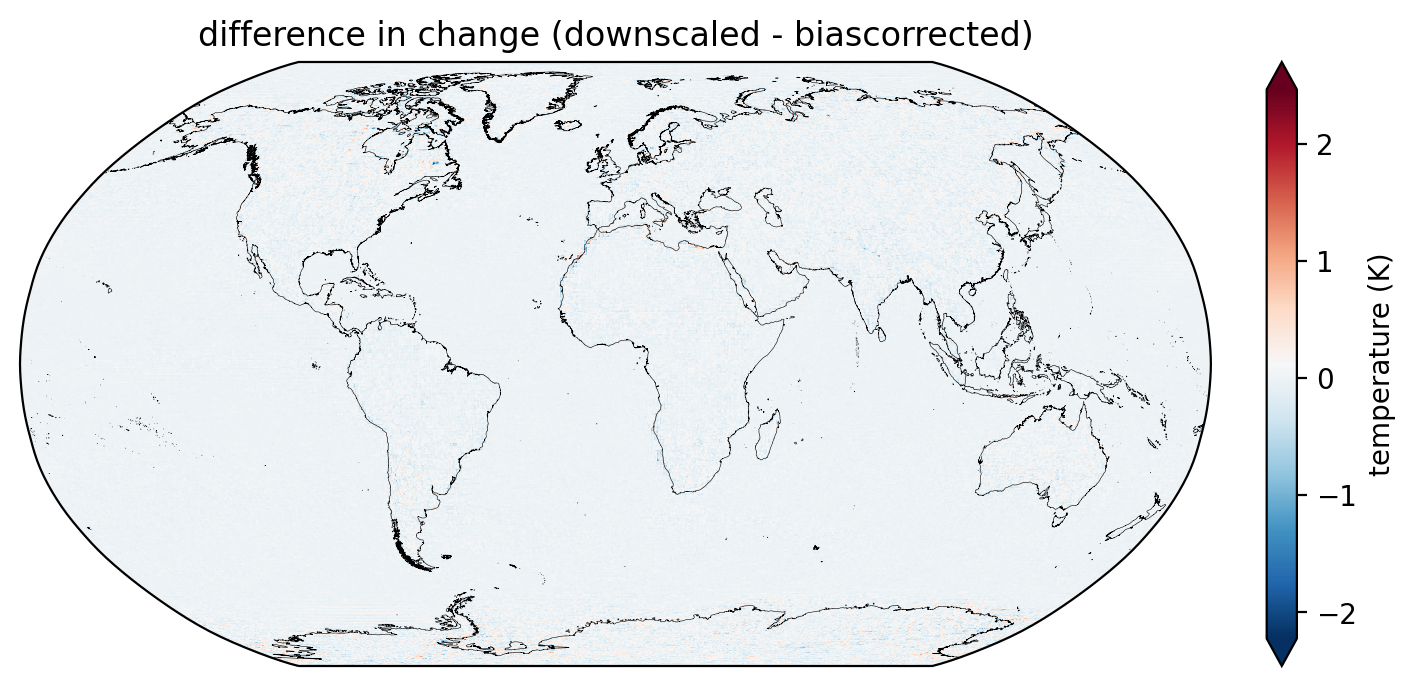

In [23]:
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(9, 4),
    subplot_kw={"projection": ccrs.Robinson()},
    dpi=200,
)
axes = np.array([axes]).reshape((1,))
coastline_feature = NaturalEarthFeature(
    "physical", "coastline", "10m", edgecolor="black", facecolor="none"
)
titles = ["difference in change (downscaled - biascorrected)"]
for j, (i, _) in enumerate(list(enumerate(all_pieces_copy))[2:]):
    v, k, kw, ax = all_pieces_copy[i], titles[j], kwargs_list[i], axes[j]
    v["lat"].attrs = dict()
    v["lon"].attrs = dict()
    ax.add_feature(coastline_feature, linewidth=0.2)
    da = all_pieces[i]
    vmax = da.max().item()
    vmin = da.min().item()
    amax = max(abs(vmax), abs(vmin))
    im = da.plot(
        add_colorbar=True,
        ax=ax,
        transform=ccrs.PlateCarree(),
        clim=(vmin, vmax),
        norm=matplotlib.colors.Normalize(vmin=-amax, vmax=amax),
        cmap="RdBu_r",
        cbar_kwargs=dict(
            fraction=0.046,
            pad=0.04,
            orientation="vertical",
            extend="both",
            label="temperature (K)",
        ),
    )
    ax.set_title(titles[j])
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.set_facecolor("white")
plt.savefig(figure_a2_output_file_path, facecolor="white", bbox_inches="tight")

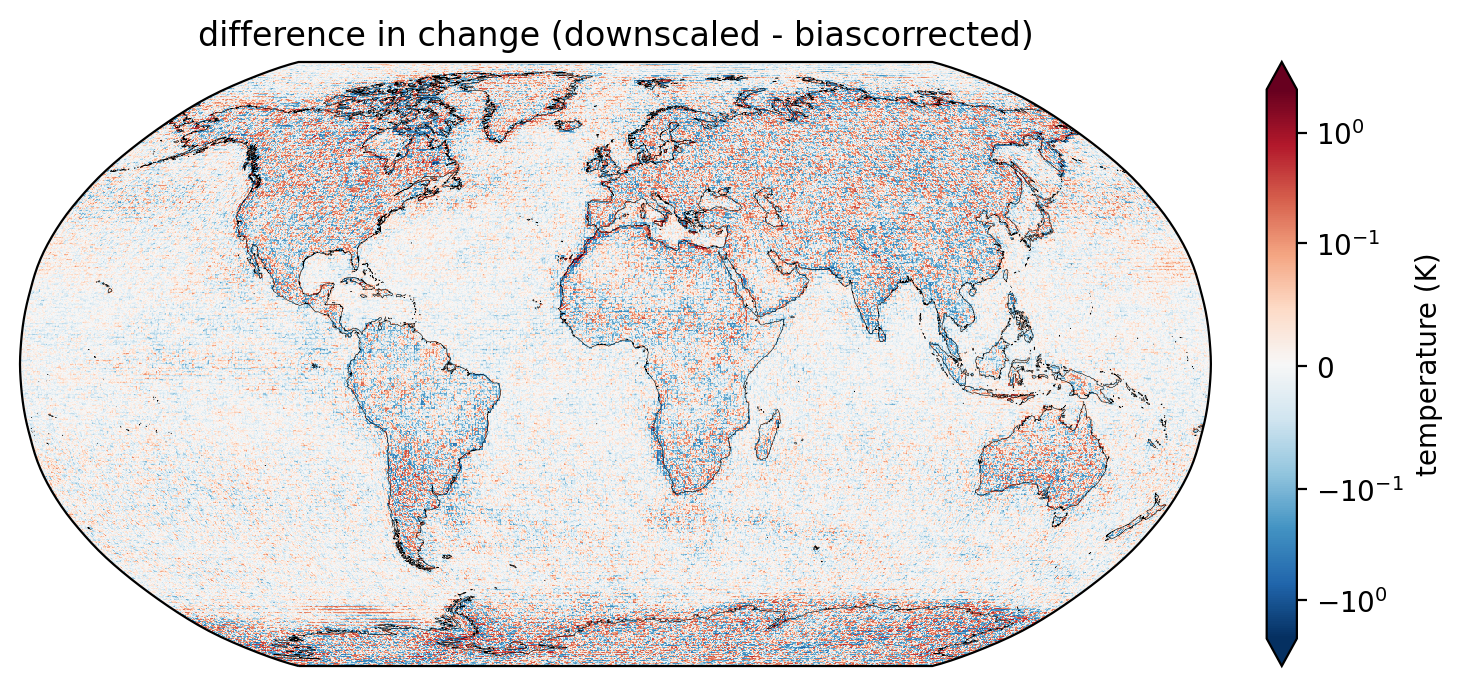

In [24]:
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(9, 4),
    subplot_kw={"projection": ccrs.Robinson()},
    dpi=200,
)
axes = np.array([axes]).reshape((1,))
coastline_feature = NaturalEarthFeature(
    "physical", "coastline", "50m", edgecolor="black", facecolor="none"
)
titles = ["difference in change (downscaled - biascorrected)"]
for j, (i, _) in enumerate(list(enumerate(all_pieces_copy))[2:]):
    v, k, kw, ax = all_pieces_copy[i], titles[j], kwargs_list[i], axes[j]
    v["lat"].attrs = dict()
    v["lon"].attrs = dict()
    ax.add_feature(coastline_feature, linewidth=0.2)
    da = all_pieces[i]
    vmax = da.max().item()
    vmin = da.min().item()
    amax = max(abs(vmax), abs(vmin))
    im = da.plot(
        add_colorbar=True,
        ax=ax,
        transform=ccrs.PlateCarree(),
        clim=(vmin, vmax),
        norm=matplotlib.colors.SymLogNorm(0.1, vmin=-amax, vmax=amax),
        cmap="RdBu_r",
        cbar_kwargs=dict(
            fraction=0.046,
            pad=0.04,
            orientation="vertical",
            extend="both",
            label="temperature (K)",
        ),
    )
    ax.set_title(titles[j])
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.set_facecolor("white")

In [25]:
client.close(), cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


(None, None)